### 정책 반복 vs 가치 반복


`정책반복`은 정책에 따라 목표에 빠르게 도달했던 경우에 수행했던 `action`을 중요한 것으로 보고, 이 때의 행동을 앞으로도 취할 수 있도록 정책을 수정하는 방법이다. 결과가 좋았던 경우에 취했던 행동을 중시한다.<br>
`가치반복`은 목표 지점부터 거슬러 올라가며 목표 지점과 가까운 상태로 에이전트를 유도해오는 방법이다. 목표 지점 외의 지점에도 가치를 부여한다.

### policy gradient 알고리즘 따라 agent 이동

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
theta_0 = np.array([[np.nan, 1, 1, np.nan],
                   [np.nan, 1, np.nan, 1],
                   [np.nan, np.nan, 1, 1],
                   [1, 1, 1, np.nan],
                   [np.nan, np.nan, 1, 1],
                   [1, np.nan, np.nan, np.nan],
                   [1, np.nan, np.nan, np.nan],
                   [1, 1, np.nan, np.nan]]) #s8은 목표 지점이라 정책이 없다

In [24]:
# 앞에서는 비율 -> softmax로

def softmax_convert(theta):
    beta = 1.0
    [m, n] = theta.shape
    pi = np.zeros((m, n))
    
    exp_theta = np.exp(beta*theta)
    
    for i in range(0, m):
        pi[i, :] = exp_theta[i,:]/ np.nansum(exp_theta[i,:])
        
    pi = np.nan_to_num(pi)
    
    return pi

In [25]:
# 초기 정책 pi_0 계산
pi_0 = softmax_convert(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


초기 상태는 비율과 softmax 값이 동일하지만, 하다 보면 달라질 것이다

In [26]:
# 행동 a와 1단계 이동 후의 상태 s 계산

def get_action_and_next_s(pi, s):
    direction = ['up', 'right', 'down','left']
    next_direct = np.random.choice(direction, p=pi[s,:])
    
    if next_direct == 'up':
        action = 0
        s_next = s - 3
    elif next_direct == 'right':
        action = 1
        s_next = s + 1
    elif next_direct == 'down':
        action = 2
        s_next = s + 3
    elif next_direct == 'left':
        action = 3
        s_next = s - 1
    
    return [action, s_next]

In [27]:
# 미로를 빠져나오는 함수
# 목표 지점에 이를 때까지 에이전트를 이동

def goal_sa(pi):
    s = 0
    s_a_history = [[0, np.nan]]
    
    while True:
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        s_a_history.append([next_s, np.nan])
        
        if next_s == 8 :
            break
        else:
            s = next_s
    
    return s_a_history

In [28]:
# 초기 정책으로 미로 빠져나오기
s_a_history = goal_sa(pi_0)
print(s_a_history)
print("걸린 단계 수 : " + str(len(s_a_history)-1))

[[0, 1], [1, 3], [0, 2], [3, 1], [4, 2], [7, 0], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
걸린 단계 수 : 10


### 정책경사 알고리즘으로
- 정책경사 알고리즘
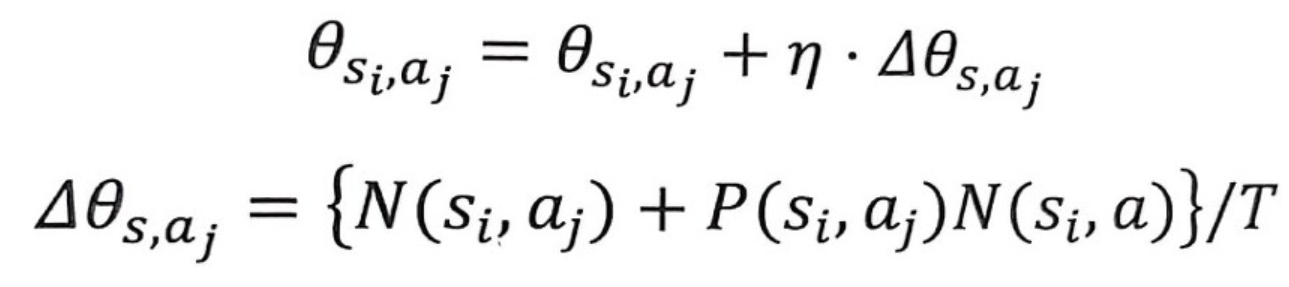

In [33]:
# theta 수정
def update_theta(theta, pi, s_a_history):
    lr = 0.1
    T = len(s_a_history)-1
    [m,n] = theta.shape
    delta_theta = theta.copy() # theta의 변화량을 구하는 세팅
                               ### 포인터 참조이므로 delta_theta = theta는 안된다.
    # delta_theta를 요소 단위로 계산
    for i in range(0, m):
        for j in range(0, n):
            if not(np.isnan([theta[i,j]])):
                SA_i = [SA for SA in s_a_history if SA[0] == i]
                SA_ij = [SA for SA in s_a_history if SA == [i,j]]
                N_i = len(SA_i)
                N_ij = len(SA_ij)
                
                delta_theta[i, j] = (N_ij - pi[i,j]*N_i)/T
        
    new_theta = theta + lr*delta_theta
    return new_theta           

In [34]:
# 정책 수정
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert(new_theta)
print(pi)

[[0.         0.5        0.5        0.        ]
 [0.         0.49750002 0.         0.50249998]
 [0.         0.         0.5        0.5       ]
 [0.33222038 0.33555925 0.33222038 0.        ]
 [0.         0.         0.50749944 0.49250056]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.50249998 0.49750002 0.         0.        ]]


In [37]:
# 정책 경사 알고리즘으로 미로 빠져나오기
stop_epsilon = 10**(-4)
theta = theta_0
pi = pi_0
is_countinue = True

while is_countinue:
    s_a_history = goal_sa(pi)
    new_theta = update_theta(theta, pi, s_a_history)
    new_pi = softmax_convert(new_theta)
    
    print(np.sum(np.abs(new_pi-pi)))
    print("목표 지점까지 걸린 단계 수 : " + str(len(s_a_history)-1))
    
    if np.sum(np.abs(new_pi-pi)) < stop_epsilon:
        is_countinue = False
    else :
        theta = new_theta
        pi = new_pi


0.01565802335414984
목표 지점까지 걸린 단계 수 : 22
0.014185496874169035
목표 지점까지 걸린 단계 수 : 36
0.016720351113403253
목표 지점까지 걸린 단계 수 : 12
0.01770608500517379
목표 지점까지 걸린 단계 수 : 18
0.013739120808793082
목표 지점까지 걸린 단계 수 : 28
0.013149268350540866
목표 지점까지 걸린 단계 수 : 38
0.015862997586469474
목표 지점까지 걸린 단계 수 : 26
0.01637694397165307
목표 지점까지 걸린 단계 수 : 40
0.012459365439103087
목표 지점까지 걸린 단계 수 : 44
0.008118425501549287
목표 지점까지 걸린 단계 수 : 84
0.013733803522789523
목표 지점까지 걸린 단계 수 : 40
0.011710931082864362
목표 지점까지 걸린 단계 수 : 78
0.016650636024018395
목표 지점까지 걸린 단계 수 : 44
0.008689738865103824
목표 지점까지 걸린 단계 수 : 86
0.008461973992030192
목표 지점까지 걸린 단계 수 : 52
0.019509764572115285
목표 지점까지 걸린 단계 수 : 18
0.021189112906182916
목표 지점까지 걸린 단계 수 : 20
0.013742543071151303
목표 지점까지 걸린 단계 수 : 38
0.024710252682835776
목표 지점까지 걸린 단계 수 : 8
0.025024757305630252
목표 지점까지 걸린 단계 수 : 10
0.017286569529291085
목표 지점까지 걸린 단계 수 : 12
0.02027007280523646
목표 지점까지 걸린 단계 수 : 8
0.025482012621545647
목표 지점까지 걸린 단계 수 : 10
0.01999298972557917
목표 지점까지 걸린 단계 수 : 18

목표 지점까지 걸린 단계 수 : 6
0.022040236383137762
목표 지점까지 걸린 단계 수 : 6
0.014881722897819888
목표 지점까지 걸린 단계 수 : 24
0.01856643746575712
목표 지점까지 걸린 단계 수 : 12
0.011183081063607353
목표 지점까지 걸린 단계 수 : 14
0.020064457056637175
목표 지점까지 걸린 단계 수 : 16
0.021554622142512997
목표 지점까지 걸린 단계 수 : 10
0.00996873306306173
목표 지점까지 걸린 단계 수 : 30
0.015155527669476476
목표 지점까지 걸린 단계 수 : 12
0.0268014213038123
목표 지점까지 걸린 단계 수 : 8
0.026540660553889928
목표 지점까지 걸린 단계 수 : 6
0.017991574250021347
목표 지점까지 걸린 단계 수 : 6
0.02618036640998697
목표 지점까지 걸린 단계 수 : 6
0.029404725976784202
목표 지점까지 걸린 단계 수 : 10
0.015329889776295264
목표 지점까지 걸린 단계 수 : 32
0.025593985095206467
목표 지점까지 걸린 단계 수 : 12
0.029189406454882133
목표 지점까지 걸린 단계 수 : 4
0.02875911480239865
목표 지점까지 걸린 단계 수 : 4
0.015105664217321957
목표 지점까지 걸린 단계 수 : 12
0.015371098164177616
목표 지점까지 걸린 단계 수 : 14
0.028306272565165297
목표 지점까지 걸린 단계 수 : 4
0.027890277717490558
목표 지점까지 걸린 단계 수 : 4
0.02748005356641159
목표 지점까지 걸린 단계 수 : 4
0.015083360598361018
목표 지점까지 걸린 단계 수 : 18
0.015774931076701693
목표 지점까지 걸린

0.015897246131972298
목표 지점까지 걸린 단계 수 : 6
0.012211045442718671
목표 지점까지 걸린 단계 수 : 4
0.01205656343814368
목표 지점까지 걸린 단계 수 : 4
0.00960965471127534
목표 지점까지 걸린 단계 수 : 6
0.011899512135797569
목표 지점까지 걸린 단계 수 : 4
0.011969708877047236
목표 지점까지 걸린 단계 수 : 8
0.011806177522883932
목표 지점까지 걸린 단계 수 : 4
0.011658408431636402
목표 지점까지 걸린 단계 수 : 4
0.015508503485591296
목표 지점까지 걸린 단계 수 : 12
0.011622812059205345
목표 지점까지 걸린 단계 수 : 4
0.019816376293091326
목표 지점까지 걸린 단계 수 : 8
0.011514010798746116
목표 지점까지 걸린 단계 수 : 4
0.014102664064025994
목표 지점까지 걸린 단계 수 : 6
0.011350481710540039
목표 지점까지 걸린 단계 수 : 4
0.01392510986364312
목표 지점까지 걸린 단계 수 : 6
0.013858627101665355
목표 지점까지 걸린 단계 수 : 6
0.010781224901609598
목표 지점까지 걸린 단계 수 : 12
0.011303807375047187
목표 지점까지 걸린 단계 수 : 4
0.009421981385346334
목표 지점까지 걸린 단계 수 : 6
0.011164516000297942
목표 지점까지 걸린 단계 수 : 4
0.016991346385321654
목표 지점까지 걸린 단계 수 : 10
0.015945801355094408
목표 지점까지 걸린 단계 수 : 16
0.00951384581704473
목표 지점까지 걸린 단계 수 : 6
0.011241136589490913
목표 지점까지 걸린 단계 수 : 4
0.01317555652715

0.005073045534933027
목표 지점까지 걸린 단계 수 : 4
0.007198965777942795
목표 지점까지 걸린 단계 수 : 6
0.005036777286198987
목표 지점까지 걸린 단계 수 : 4
0.004989502206512217
목표 지점까지 걸린 단계 수 : 4
0.008030230498940583
목표 지점까지 걸린 단계 수 : 8
0.0049969238347761374
목표 지점까지 걸린 단계 수 : 4
0.009029401898661846
목표 지점까지 걸린 단계 수 : 6
0.004980038580586071
목표 지점까지 걸린 단계 수 : 4
0.004933338674600898
목표 지점까지 걸린 단계 수 : 4
0.012572964569435977
목표 지점까지 걸린 단계 수 : 14
0.007083057709826424
목표 지점까지 걸린 단계 수 : 6
0.00909289019971507
목표 지점까지 걸린 단계 수 : 6
0.005039511274124206
목표 지점까지 걸린 단계 수 : 4
0.009412333128607092
목표 지점까지 걸린 단계 수 : 8
0.013109262301616006
목표 지점까지 걸린 단계 수 : 6
0.005041139466682276
목표 지점까지 걸린 단계 수 : 4
0.004993624196872881
목표 지점까지 걸린 단계 수 : 4
0.007058404368420604
목표 지점까지 걸린 단계 수 : 6
0.004969739235332768
목표 지점까지 걸린 단계 수 : 4
0.012732895527772375
목표 지점까지 걸린 단계 수 : 18
0.004941784744015215
목표 지점까지 걸린 단계 수 : 4
0.007032350317514563
목표 지점까지 걸린 단계 수 : 6
0.004919982210062623
목표 지점까지 걸린 단계 수 : 4
0.004874169432909373
목표 지점까지 걸린 단계 수 : 4
0.004828960361

0.0033717333738429306
목표 지점까지 걸린 단계 수 : 4
0.0033446793103430322
목표 지점까지 걸린 단계 수 : 4
0.007175652729062849
목표 지점까지 걸린 단계 수 : 6
0.005766356264840275
목표 지점까지 걸린 단계 수 : 6
0.00713913161799648
목표 지점까지 걸린 단계 수 : 6
0.0033820322473181313
목표 지점까지 걸린 단계 수 : 4
0.003354809157672445
목표 지점까지 걸린 단계 수 : 4
0.007129468515550318
목표 지점까지 걸린 단계 수 : 6
0.007863185556621445
목표 지점까지 걸린 단계 수 : 10
0.00726619351826184
목표 지점까지 걸린 단계 수 : 6
0.0034467825873214994
목표 지점까지 걸린 단계 수 : 4
0.0034186665218005965
목표 지점까지 걸린 단계 수 : 4
0.003390881831398601
목표 지점까지 걸린 단계 수 : 4
0.003363423491885481
목표 지점까지 걸린 단계 수 : 4
0.005873081864415222
목표 지점까지 걸린 단계 수 : 6
0.011068804462157217
목표 지점까지 걸린 단계 수 : 6
0.0033621640537237485
목표 지점까지 걸린 단계 수 : 4
0.00713690696620381
목표 지점까지 걸린 단계 수 : 6
0.0033564455594985512
목표 지점까지 걸린 단계 수 : 4
0.003329461509075711
목표 지점까지 걸린 단계 수 : 4
0.006919002833668343
목표 지점까지 걸린 단계 수 : 8
0.0033448329299366475
목표 지점까지 걸린 단계 수 : 4
0.005863303590476404
목표 지점까지 걸린 단계 수 : 6
0.0033400512236107585
목표 지점까지 걸린 단계 수 : 4
0.0071183

목표 지점까지 걸린 단계 수 : 4
0.002390090253858196
목표 지점까지 걸린 단계 수 : 4
0.002372523615724577
목표 지점까지 걸린 단계 수 : 4
0.006358965169610639
목표 지점까지 걸린 단계 수 : 6
0.002393715877007263
목표 지점까지 걸린 단계 수 : 4
0.0023760024088536197
목표 지점까지 걸린 단계 수 : 4
0.002358486377194338
목표 지점까지 걸린 단계 수 : 4
0.006890562366512171
목표 지점까지 걸린 단계 수 : 8
0.0023862870231529665
목표 지점까지 걸린 단계 수 : 4
0.0023686189457555046
목표 지점까지 걸린 단계 수 : 4
0.002351148020181472
목표 지점까지 걸린 단계 수 : 4
0.012284901928305177
목표 지점까지 걸린 단계 수 : 16
0.0023343384364327563
목표 지점까지 걸린 단계 수 : 4
0.0023172696384411925
목표 지점까지 걸린 단계 수 : 4
0.0023003889509098582
목표 지점까지 걸린 단계 수 : 4
0.0045777910189951435
목표 지점까지 걸린 단계 수 : 6
0.009355012480679832
목표 지점까지 걸린 단계 수 : 8
0.00236004730442662
목표 지점까지 걸린 단계 수 : 4
0.005830389759737292
목표 지점까지 걸린 단계 수 : 6
0.0023517858369722644
목표 지점까지 걸린 단계 수 : 4
0.002334475405520349
목표 지점까지 걸린 단계 수 : 4
0.0023173571142110286
목표 지점까지 걸린 단계 수 : 4
0.0023004281285659844
목표 지점까지 걸린 단계 수 : 4
0.002283685665653949
목표 지점까지 걸린 단계 수 : 4
0.002267126992988547
목표 지점까

0.0013413511541858908
목표 지점까지 걸린 단계 수 : 4
0.001334096322683262
목표 지점까지 걸린 단계 수 : 4
0.0013268998900021756
목표 지점까지 걸린 단계 수 : 4
0.0013197612341152506
목표 지점까지 걸린 단계 수 : 4
0.0013126797412093133
목표 지점까지 걸린 단계 수 : 4
0.0013056548055526487
목표 지점까지 걸린 단계 수 : 4
0.0012986858293696502
목표 지점까지 걸린 단계 수 : 4
0.0012917722227184514
목표 지점까지 걸린 단계 수 : 4
0.00128491340336611
목표 지점까지 걸린 단계 수 : 4
0.001278108796670313
목표 지점까지 걸린 단계 수 : 4
0.001271357835462228
목표 지점까지 걸린 단계 수 : 4
0.007844242873390292
목표 지점까지 걸린 단계 수 : 6
0.0012690564107573007
목표 지점까지 걸린 단계 수 : 4
0.0012623978985013481
목표 지점까지 걸린 단계 수 : 4
0.0012557913560159173
목표 지점까지 걸린 단계 수 : 4
0.001249236246495207
목표 지점까지 걸린 단계 수 : 4
0.0012427320400084374
목표 지점까지 걸린 단계 수 : 4
0.0012362782133962733
목표 지점까지 걸린 단계 수 : 4
0.003656103744850918
목표 지점까지 걸린 단계 수 : 6
0.004482558263265379
목표 지점까지 걸린 단계 수 : 6
0.0012601943287558273
목표 지점까지 걸린 단계 수 : 4
0.0012535820846720572
목표 지점까지 걸린 단계 수 : 4
0.0012470215370265006
목표 지점까지 걸린 단계 수 : 4
0.004514584837089379
목표 지점까지 걸린 단계 수 : 6
0.

0.0008560830275428123
목표 지점까지 걸린 단계 수 : 4
0.0008522285085296073
목표 지점까지 걸린 단계 수 : 4
0.0008484005267485398
목표 지점까지 걸린 단계 수 : 4
0.0008445988343925293
목표 지점까지 걸린 단계 수 : 4
0.003032479682770879
목표 지점까지 걸린 단계 수 : 6
0.0008460907504448771
목표 지점까지 걸린 단계 수 : 4
0.0008423186281800478
목표 지점까지 걸린 단계 수 : 4
0.0008385721616054921
목표 지점까지 걸린 단계 수 : 4
0.003849080539013238
목표 지점까지 걸린 단계 수 : 6
0.0008516117554803297
목표 지점까지 걸린 단계 수 : 4
0.0008477756520791635
목표 지점까지 걸린 단계 수 : 4
0.0008439660176788599
목표 지점까지 걸린 단계 수 : 4
0.0008401826042301677
목표 지점까지 걸린 단계 수 : 4
0.0008364251666307457
목표 지점까지 걸린 단계 수 : 4
0.0008326934626786339
목표 지점까지 걸린 단계 수 : 4
0.000828987253034822
목표 지점까지 걸린 단계 수 : 4
0.0008253063011780283
목표 지점까지 걸린 단계 수 : 4
0.0008216503733684336
목표 지점까지 걸린 단계 수 : 4
0.0008180192386056384
목표 지점까지 걸린 단계 수 : 4
0.002785738433374055
목표 지점까지 걸린 단계 수 : 6
0.0008219872943760753
목표 지점까지 걸린 단계 수 : 4
0.0008183639957038587
목표 지점까지 걸린 단계 수 : 4
0.0008147650947538977
목표 지점까지 걸린 단계 수 : 4
0.0008111903688593734
목표 지점까지 걸린 단계 수 

0.0006983759608294553
목표 지점까지 걸린 단계 수 : 4
0.0025330982882906146
목표 지점까지 걸린 단계 수 : 6
0.0007008606611922132
목표 지점까지 걸린 단계 수 : 4
0.0036122860868494575
목표 지점까지 걸린 단계 수 : 6
0.0007139214737320494
목표 지점까지 걸린 단계 수 : 4
0.0007108976791417206
목표 지점까지 걸린 단계 수 : 4
0.000707893834261418
목표 지점까지 걸린 단계 수 : 4
0.0007049097580548169
목표 지점까지 걸린 단계 수 : 4
0.0007019452715817352
목표 지점까지 걸린 단계 수 : 4
0.0006990001979687611
목표 지점까지 걸린 단계 수 : 4
0.0006960743623837286
목표 지점까지 걸린 단계 수 : 4
0.000693167592001432
목표 지점까지 걸린 단계 수 : 4
0.000690279715982553
목표 지점까지 걸린 단계 수 : 4
0.0006874105654390665
목표 지점까지 걸린 단계 수 : 4
0.0006845599734122756
목표 지점까지 걸린 단계 수 : 4
0.0035914300904145054
목표 지점까지 걸린 단계 수 : 6
0.0006977027222798103
목표 지점까지 걸린 단계 수 : 4
0.0024177888616987477
목표 지점까지 걸린 단계 수 : 6
0.0025574629118987197
목표 지점까지 걸린 단계 수 : 6
0.0007056848821412783
목표 지점까지 걸린 단계 수 : 4
0.0007027143953452636
목표 지점까지 걸린 단계 수 : 4
0.0006997633685458908
목표 지점까지 걸린 단계 수 : 4
0.0006968316265243066
목표 지점까지 걸린 단계 수 : 4
0.0006939189960779996
목표 지점까지 걸린 단계 수

0.00044393156979392195
목표 지점까지 걸린 단계 수 : 4
0.00044251562559060806
목표 지점까지 걸린 단계 수 : 4
0.00044110649994485995
목표 지점까지 걸린 단계 수 : 4
0.0004397041487596738
목표 지점까지 걸린 단계 수 : 4
0.00043830852829621764
목표 지점까지 걸린 단계 수 : 4
0.0004369195951730784
목표 지점까지 걸린 단계 수 : 4
0.00043553730635697424
목표 지점까지 걸린 단계 수 : 4
0.0004341616191664288
목표 지점까지 걸린 단계 수 : 4
0.00043279249126509933
목표 지점까지 걸린 단계 수 : 4
0.00913890030992693
목표 지점까지 걸린 단계 수 : 8
0.002644644199452536
목표 지점까지 걸린 단계 수 : 6
0.00044609351004906705
목표 지점까지 걸린 단계 수 : 4
0.00196009577894252
목표 지점까지 걸린 단계 수 : 6
0.0004474225926031396
목표 지점까지 걸린 단계 수 : 4
0.00044599319736116083
목표 지점까지 걸린 단계 수 : 4
0.0022050149322168054
목표 지점까지 걸린 단계 수 : 6
0.0004498541790477831
목표 지점까지 걸린 단계 수 : 4
0.00044841431023330547
목표 지점까지 걸린 단계 수 : 4
0.002682293513695252
목표 지점까지 걸린 단계 수 : 6
0.00045521353012038107
목표 지점까지 걸린 단계 수 : 4
0.00045374019953580563
목표 지점까지 걸린 단계 수 : 4
0.0004522740829649499
목표 지점까지 걸린 단계 수 : 4
0.0004508151328686573
목표 지점까지 걸린 단계 수 : 4
0.0004493633020999088
목표 지점까지

0.0003341258734322304
목표 지점까지 걸린 단계 수 : 4
0.0003331989180605198
목표 지점까지 걸린 단계 수 : 4
0.00033227584917897013
목표 지점까지 걸린 단계 수 : 4
0.0003313566448790613
목표 지점까지 걸린 단계 수 : 4
0.0003304412834087625
목표 지점까지 걸린 단계 수 : 4
0.0003295297431702114
목표 지점까지 걸린 단계 수 : 4
0.00032862200271802783
목표 지점까지 걸린 단계 수 : 4
0.001927202896249671
목표 지점까지 걸린 단계 수 : 6
0.0003320598167490113
목표 지점까지 걸린 단계 수 : 4
0.009765387533224888
목표 지점까지 걸린 단계 수 : 12
0.00033256183251006294
목표 지점까지 걸린 단계 수 : 4
0.0003316431244793118
목표 지점까지 걸린 단계 수 : 4
0.00033072824568944337
목표 지점까지 걸린 단계 수 : 4
0.001956981669598394
목표 지점까지 걸린 단계 수 : 6
0.00033432479382272673
목표 지점까지 걸린 단계 수 : 4
0.0003333987576837061
목표 지점까지 걸린 단계 수 : 4
0.0003324765892894939
목표 지점까지 걸린 단계 수 : 4
0.0003315582669801663
목표 지점까지 걸린 단계 수 : 4
0.0003306437692488992
목표 지점까지 걸린 단계 수 : 4
0.0003297330747373227
목표 지점까지 걸린 단계 수 : 4
0.0003288261622413531
목표 지점까지 걸린 단계 수 : 4
0.002259757431180634
목표 지점까지 걸린 단계 수 : 6
0.00033388005701677145
목표 지점까지 걸린 단계 수 : 4
0.00033295183676598783
목표 지점까지 

0.00028869344166387867
목표 지점까지 걸린 단계 수 : 4
0.0002879419294723948
목표 지점까지 걸린 단계 수 : 4
0.005390479192102088
목표 지점까지 걸린 단계 수 : 6
0.0002896820104016408
목표 지점까지 걸린 단계 수 : 4
0.00028892893730870367
목표 지점까지 걸린 단계 수 : 4
0.0002881788316427651
목표 지점까지 걸린 단계 수 : 4
0.0002874316776490353
목표 지점까지 걸린 단계 수 : 4
0.0002866874596744867
목표 지점까지 걸린 단계 수 : 4
0.0002859461621738807
목표 지점까지 걸린 단계 수 : 4
0.0002852077697046186
목표 지점까지 걸린 단계 수 : 4
0.0002844722669278314
목표 지점까지 걸린 단계 수 : 4
0.00028373963860561097
목표 지점까지 걸린 단계 수 : 4
0.0002830098696023839
목표 지점까지 걸린 단계 수 : 4
0.0002822829448832602
목표 지점까지 걸린 단계 수 : 4
0.00028155884951348853
목표 지점까지 걸린 단계 수 : 4
0.0002808375686550908
목표 지점까지 걸린 단계 수 : 4
0.0002801190875712026
목표 지점까지 걸린 단계 수 : 4
0.0002794033916207368
목표 지점까지 걸린 단계 수 : 4
0.00027869046625824886
목표 지점까지 걸린 단계 수 : 4
0.000277980297037201
목표 지점까지 걸린 단계 수 : 4
0.001766321133490751
목표 지점까지 걸린 단계 수 : 6
0.00028101241935836463
목표 지점까지 걸린 단계 수 : 4
0.0002802935682128631
목표 지점까지 걸린 단계 수 : 4
0.00027957750079475943
목표 지점까지 

목표 지점까지 걸린 단계 수 : 4
0.00023449073734899822
목표 지점까지 걸린 단계 수 : 4
0.0002339483953375833
목표 지점까지 걸린 단계 수 : 4
0.0002334079400601631
목표 지점까지 걸린 단계 수 : 4
0.005166598130736954
목표 지점까지 걸린 단계 수 : 6
0.00023523958407627166
목표 지점까지 걸린 단계 수 : 4
0.00023469586670640807
목표 지점까지 걸린 단계 수 : 4
0.0002341540371709576
목표 지점까지 걸린 단계 수 : 4
0.0002336140867085952
목표 지점까지 걸린 단계 수 : 4
0.00023307600661029437
목표 지점까지 걸린 단계 수 : 4
0.0016408206004773773
목표 지점까지 걸린 단계 수 : 6
0.00023584652183880964
목표 지점까지 걸린 단계 수 : 4
0.00023530043111772217
목표 지점까지 걸린 단계 수 : 4
0.00023475623970042533
목표 지점까지 걸린 단계 수 : 4
0.00023421393876010138
목표 지점까지 걸린 단계 수 : 4
0.00023367351952243223
목표 지점까지 걸린 단계 수 : 4
0.00023313497326460375
목표 지점까지 걸린 단계 수 : 4
0.00023259829131123608
목표 지점까지 걸린 단계 수 : 4
0.000232063465042006
목표 지점까지 걸린 단계 수 : 4
0.00023153048588144334
목표 지점까지 걸린 단계 수 : 4
0.0002309993453087425
목표 지점까지 걸린 단계 수 : 4
0.000230470034847996
목표 지점까지 걸린 단계 수 : 4
0.00022994254607529296
목표 지점까지 걸린 단계 수 : 4
0.00022941687061333454
목표 지점까지 걸린 단계 수 : 4
0.0

0.00018241416299622122
목표 지점까지 걸린 단계 수 : 4
0.0001820402143208246
목표 지점까지 걸린 단계 수 : 4
0.0001816674197205291
목표 지점까지 걸린 단계 수 : 4
0.00018129577443091495
목표 지점까지 걸린 단계 수 : 4
0.00018092527371185198
목표 지점까지 걸린 단계 수 : 4
0.00018055591284803219
목표 지점까지 걸린 단계 수 : 4
0.0001801876871480989
목표 지점까지 걸린 단계 수 : 4
0.00017982059194428766
목표 지점까지 걸린 단계 수 : 4
0.00017945462259493124
목표 지점까지 걸린 단계 수 : 4
0.00017908977447968558
목표 지점까지 걸린 단계 수 : 4
0.0001787260430039829
목표 지점까지 걸린 단계 수 : 4
0.0001783634235956507
목표 지점까지 걸린 단계 수 : 4
0.00017800191170696915
목표 지점까지 걸린 단계 수 : 4
0.0001776415028122199
목표 지점까지 걸린 단계 수 : 4
0.0001772821924099343
목표 지점까지 걸린 단계 수 : 4
0.00017692397602145186
목표 지점까지 걸린 단계 수 : 4
0.00017656684919038768
목표 지점까지 걸린 단계 수 : 4
0.0014676274980511776
목표 지점까지 걸린 단계 수 : 6
0.00017913181838614782
목표 지점까지 걸린 단계 수 : 4
0.000178767304251733
목표 지점까지 걸린 단계 수 : 4
0.00017840390766009698
목표 지점까지 걸린 단계 수 : 4
0.004766554894621031
목표 지점까지 걸린 단계 수 : 6
0.0015224071549930877
목표 지점까지 걸린 단계 수 : 6
0.00018295022901415603
목

0.00015467625613816913
목표 지점까지 걸린 단계 수 : 4
0.00015438170183190367
목표 지점까지 걸린 단계 수 : 4
0.00015408799551649977
목표 지점까지 걸린 단계 수 : 4
0.00015379513391764604
목표 지점까지 걸린 단계 수 : 4
0.00015350311377300419
목표 지점까지 걸린 단계 수 : 4
0.00015321193183913222
목표 지점까지 걸린 단계 수 : 4
0.00015292158488696556
목표 지점까지 걸린 단계 수 : 4
0.00015263206970292202
목표 지점까지 걸린 단계 수 : 4
0.00015234338308942053
목표 지점까지 걸린 단계 수 : 4
0.00015205552186392177
목표 지점까지 걸린 단계 수 : 4
0.00015176848286031427
목표 지점까지 걸린 단계 수 : 4
0.0001514822629257919
목표 지점까지 걸린 단계 수 : 4
0.00015119685892434932
목표 지점까지 걸린 단계 수 : 4
0.0001509122677346604
목표 지점까지 걸린 단계 수 : 4
0.00015062848625049634
목표 지점까지 걸린 단계 수 : 4
0.00015034551137957375
목표 지점까지 걸린 단계 수 : 4
0.00015006334004564852
목표 지점까지 걸린 단계 수 : 4
0.0001497819691873275
목표 지점까지 걸린 단계 수 : 4
0.000149501395756051
목표 지점까지 걸린 단계 수 : 4
0.0014037977580113742
목표 지점까지 걸린 단계 수 : 6
0.00015183212002978577
목표 지점까지 걸린 단계 수 : 4
0.0001515450700797661
목표 지점까지 걸린 단계 수 : 4
0.00015125884133152662
목표 지점까지 걸린 단계 수 : 4
0.0001509734306301

0.00012657713647315494
목표 지점까지 걸린 단계 수 : 4
0.00012635891636360135
목표 지점까지 걸린 단계 수 : 4
0.00012614126559674053
목표 지점까지 걸린 단계 수 : 4
0.00012592418217643314
목표 지점까지 걸린 단계 수 : 4
0.00012570766411421248
목표 지점까지 걸린 단계 수 : 4
0.00012549170943160215
목표 지점까지 걸린 단계 수 : 4
0.00012527631615822862
목표 지점까지 걸린 단계 수 : 4
0.00012506148233215955
목표 지점까지 걸린 단계 수 : 4
0.00012484720600033396
목표 지점까지 걸린 단계 수 : 4
0.00012463348521867847
목표 지점까지 걸린 단계 수 : 4
0.00012442031805131107
목표 지점까지 걸린 단계 수 : 4
0.00012420770257075102
목표 지점까지 걸린 단계 수 : 4
0.0013496921721784724
목표 지점까지 걸린 단계 수 : 6
0.00012631082384267737
목표 지점까지 걸린 단계 수 : 4
0.00012609253052827535
목표 지점까지 걸린 단계 수 : 4
0.00012587480940210068
목표 지점까지 걸린 단계 수 : 4
0.00012565765844505666
목표 지점까지 걸린 단계 수 : 4
0.00012544107564509133
목표 지점까지 걸린 단계 수 : 4
0.00012522505900047602
목표 지점까지 걸린 단계 수 : 4
0.0001250096065185339
목표 지점까지 걸린 단계 수 : 4
0.00012479471621408902
목표 지점까지 걸린 단계 수 : 4
0.00012458038611157587
목표 지점까지 걸린 단계 수 : 4
0.00012436661424511386
목표 지점까지 걸린 단계 수 : 4
0.00012415339

목표 지점까지 걸린 단계 수 : 4
0.0001017564132088887
목표 지점까지 걸린 단계 수 : 4
0.0001016000499868084
목표 지점까지 걸린 단계 수 : 4
0.00010144404942821934
목표 지점까지 걸린 단계 수 : 4
0.00010128841040346441
목표 지점까지 걸린 단계 수 : 4
0.00010113313178808717
목표 지점까지 걸린 단계 수 : 4
0.00010097821246241381
목표 지점까지 걸린 단계 수 : 4
0.00010082365130977856
목표 지점까지 걸린 단계 수 : 4
0.0001006694472190997
목표 지점까지 걸린 단계 수 : 4
0.00010051559908340335
목표 지점까지 걸린 단계 수 : 4
0.0001003621058002762
목표 지점까지 걸린 단계 수 : 4
0.00010020896627024704
목표 지점까지 걸린 단계 수 : 4
0.00010005617939963171
목표 지점까지 걸린 단계 수 : 4
9.990374409856763e-05
목표 지점까지 걸린 단계 수 : 4


In [38]:
# 학습이 끝난 정책 확인
np.set_printoptions(precision = 3, suppress=True) # precision : 유효 자리수, suppress : 지수 표시 여부
print(pi)

[[0.    0.013 0.987 0.   ]
 [0.    0.255 0.    0.745]
 [0.    0.    0.426 0.574]
 [0.011 0.978 0.011 0.   ]
 [0.    0.    0.982 0.018]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.013 0.987 0.    0.   ]]


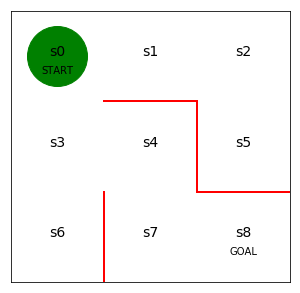

In [40]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

# 붉은 벽
plt.plot([1,1], [0,1], color='red', linewidth=2)
plt.plot([1,2], [2,2], color='red', linewidth=2)
plt.plot([2,2], [2,1], color='red', linewidth=2)
plt.plot([2,3], [1,1], color='red', linewidth=2)

# 각 state 표현
plt.text(0.5, 2.5, 's0', size=14, ha ='center')
plt.text(1.5, 2.5, 's1', size=14, ha ='center')
plt.text(2.5, 2.5, 's2', size=14, ha ='center')
plt.text(0.5, 1.5, 's3', size=14, ha ='center')
plt.text(1.5, 1.5, 's4', size=14, ha ='center')
plt.text(2.5, 1.5, 's5', size=14, ha ='center')
plt.text(0.5, 0.5, 's6', size=14, ha ='center')
plt.text(1.5, 0.5, 's7', size=14, ha ='center')
plt.text(2.5, 0.5, 's8', size=14, ha ='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 그림 범위 및 눈금 제거
ax.set_xlim(0.0,3.0)
ax.set_ylim(0.0,3.0)
plt.tick_params(axis='both',which='both', bottom=False, top=False,
               labelbottom=False, right=False, left=False, labelleft=False)

# agent(원)
line, = ax.plot([0.5],[2.5], marker="o",color='g', markersize=60)

In [43]:
# agent의 이동 시각화
from matplotlib import animation
from IPython.display import HTML

def init():
    '''배경 이미지 초기화'''
    line.set_data([],[])
    return (line,)

def animate(i):
    '''프레임 단위로 이미지 생성'''
    state = s_a_history[i][0]
    x = (state % 3) + 0.5 # x 좌표
    y = 2.5 - int(state/3) # y 좌표
    line.set_data(x,y)
    return (line, )

anim = animation.FuncAnimation(fig, animate, init_func=init,
                              frames = len(s_a_history),
                              interval = 200, repeat=False)

HTML(anim.to_jshtml())
    